In [304]:
import numpy as np
import json
import matplotlib.pyplot as plt
import geopy.distance
import os
import networkx as nx

#https://toreopsahl.com/datasets/#usairports

In [305]:
code_airport = {}
with open("USairport_2010/USairport_2010_codes.txt", "r") as txt_file:
    line = txt_file.readline()
    while line:
        arr = line.split()
        code_airport[int(arr[0])-1] = arr[1]
        line = txt_file.readline()
    airport_num = int(arr[0])

In [306]:
airport_location = {}
with open("USairport_2010/openflight_airports.txt", "r") as txt_file:
    line = txt_file.readline()
    line = txt_file.readline()
    arr = line.split()
    print(arr)
    
    while line:
        arr = line.split()
        airport_location[arr[-7]] = [float(arr[-5]), float(arr[-4])]
        line = txt_file.readline()

['1', '"Goroka"', '"Goroka"', '"Papua', 'New', 'Guinea"', '"GKA"', '"AYGA"', '-6.081689', '145.391881', '5282', '10', '"U"']


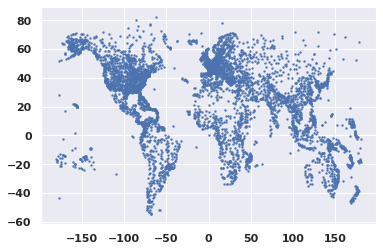

In [307]:
latitude = [airport_location[v][0] for v in airport_location]
longitude = [airport_location[v][1] for v in airport_location]
plt.scatter(longitude, latitude,s=5.0,linewidths=0.1)

In [308]:
match = 0
match_idx = []
for code in code_airport:
    airport = code_airport[code]
    if airport in airport_location:
        match += 1
        match_idx.append(code)

In [309]:
a = np.zeros((airport_num, airport_num))
w = np.zeros((airport_num, airport_num))
d = np.zeros((airport_num, airport_num))
distance = geopy.distance.geodesic

with open("USairport_2010/USairport_2010.txt", "r") as txt_file:
    line = txt_file.readline()
    while line:
        arr = line.split()
        w[int(arr[0])-1][int(arr[1])-1] = arr[2]
        a[int(arr[0])-1][int(arr[1])-1] = 1
        a[int(arr[1])-1][int(arr[0])-1] = 1
        airport1 = code_airport[int(arr[0])-1]
        airport2 = code_airport[int(arr[1])-1]
        if airport1 in airport_location and airport2 in airport_location:
            d[int(arr[0])-1][int(arr[1])-1] = distance(airport_location[airport1], airport_location[airport2]).km
            d[int(arr[1])-1][int(arr[0])-1] = d[int(arr[0])-1][int(arr[1])-1]
        line = txt_file.readline()
a = a[match_idx, :][:, match_idx]
w = w[match_idx, :][:, match_idx]
d = d[match_idx, :][:, match_idx]

In [213]:
d_full = np.zeros((len(match_idx), len(match_idx)))
for i in range(len(match_idx)):
    code1 = match_idx[i]
    airport1 = code_airport[code1]
    for j in range(i+1, len(match_idx)):
        code2 = match_idx[j]
        airport2 = code_airport[code2]
        d_full[i,j] = distance(airport_location[airport1], airport_location[airport2]).km
        d_full[j,i] = d_full[i,j]

## 49 nodes subnet

In [8]:
subnet_node = 120
subnet_idx = np.random.choice(match, subnet_node, replace = False)
sub_a = a[subnet_idx,:][:,subnet_idx]
sub_w = w[subnet_idx,:][:,subnet_idx]
sub_d = d[subnet_idx,:][:,subnet_idx]

(array([71., 32.,  3.,  1.,  3.,  1.,  2.,  1.,  0.,  0.,  2.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.88461538,  1.76923077,  2.65384615,  3.53846154,
         4.42307692,  5.30769231,  6.19230769,  7.07692308,  7.96153846,
         8.84615385,  9.73076923, 10.61538462, 11.5       , 12.38461538,
        13.26923077, 14.15384615, 15.03846154, 15.92307692, 16.80769231,
        17.69230769, 18.57692308, 19.46153846, 20.34615385, 21.23076923,
        22.11538462, 23.        ]),
 <BarContainer object of 26 artists>)

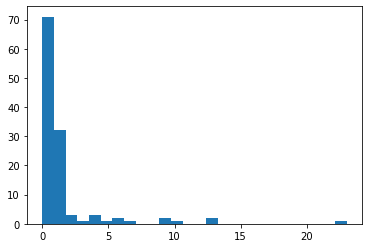

In [9]:
plt.hist(np.sum(sub_a, axis = 0), bins = 26)

In [10]:
nz_axis = np.where(np.sum(sub_a, axis = 0)!=0)[0]
nz_sub_a = sub_a[nz_axis,:][:,nz_axis]
nz_sub_w = sub_w[nz_axis,:][:,nz_axis]
nz_sub_d = sub_d[nz_axis,:][:,nz_axis]
#assert np.sum((nz_sub_a != 0) != (nz_sub_w!=0)) == 0
assert np.sum((nz_sub_a != 0) != (nz_sub_d!=0)) == 0

(array([32.,  3.,  1.,  3.,  1.,  0.,  2.,  1.,  0.,  2.,  0.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([ 1.        ,  1.81481481,  2.62962963,  3.44444444,  4.25925926,
         5.07407407,  5.88888889,  6.7037037 ,  7.51851852,  8.33333333,
         9.14814815,  9.96296296, 10.77777778, 11.59259259, 12.40740741,
        13.22222222, 14.03703704, 14.85185185, 15.66666667, 16.48148148,
        17.2962963 , 18.11111111, 18.92592593, 19.74074074, 20.55555556,
        21.37037037, 22.18518519, 23.        ]),
 <BarContainer object of 27 artists>)

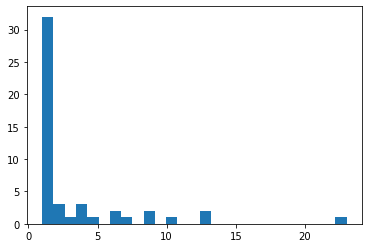

In [12]:
plt.hist(np.sum(nz_sub_a, axis = 0), bins = 27)

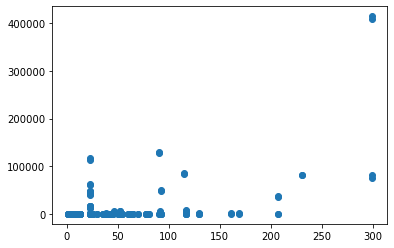

In [13]:
degree_list = np.sum(nz_sub_a, axis = 0)
product_of_degrees = []
weight_edge = []
for i in range(nz_sub_a.shape[0]):
    for j in range(nz_sub_a.shape[0]):
        if nz_sub_a[i,j] != 0:
            product_of_degrees.append(degree_list[i] * degree_list[j])
            weight_edge.append(nz_sub_w[i,j])
plt.scatter(product_of_degrees, weight_edge)

(array([2.315e+03, 5.100e+01, 1.800e+01, 1.000e+01, 2.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.0025, 0.1345, 0.2665, 0.3985, 0.5305, 0.6625, 0.7945, 0.9265,
        1.0585, 1.1905, 1.3225]),
 <BarContainer object of 10 artists>)

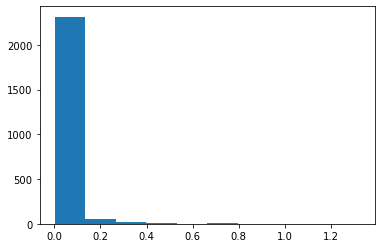

In [14]:
u = np.outer(degree_list, degree_list) / 400
plt.hist(u.flatten())

In [22]:
demand = []
for i in range(nz_sub_a.shape[0]):
    demand.append(np.sum(nz_sub_w, axis=1)[i] - np.sum(nz_sub_w, axis=0)[i])
demand = np.array(demand) / 1000

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  4., 23.,  7.,  0.,  4.,  1.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-4.695   , -4.428925, -4.16285 , -3.896775, -3.6307  , -3.364625,
        -3.09855 , -2.832475, -2.5664  , -2.300325, -2.03425 , -1.768175,
        -1.5021  , -1.236025, -0.96995 , -0.703875, -0.4378  , -0.171725,
         0.09435 ,  0.360425,  0.6265  ,  0.892575,  1.15865 ,  1.424725,
         1.6908  ,  1.956875,  2.22295 ,  2.489025,  2.7551  ,  3.021175,
         3.28725 ,  3.553325,  3.8194  ,  4.085475,  4.35155 ,  4.617625,
         4.8837  ,  5.149775,  5.41585 ,  5.681925,  5.948   ]),
 <BarContainer object of 40 artists>)

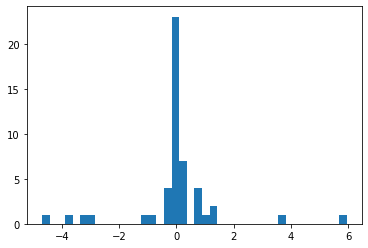

In [23]:
plt.hist(np.array(demand), bins = 40)

In [17]:
np.sum(nz_sub_a)

154.0

(array([36., 16., 20.,  8., 26.,  8., 14.,  8.,  2.,  0.,  0.,  0.,  4.,
         2.,  0.,  2.,  4.,  2.,  0.,  2.]),
 array([  26.86527195,  524.82513722, 1022.78500248, 1520.74486775,
        2018.70473301, 2516.66459828, 3014.62446354, 3512.58432881,
        4010.54419407, 4508.50405934, 5006.4639246 , 5504.42378987,
        6002.38365513, 6500.3435204 , 6998.30338566, 7496.26325093,
        7994.22311619, 8492.18298146, 8990.14284672, 9488.10271199,
        9986.06257725]),
 <BarContainer object of 20 artists>)

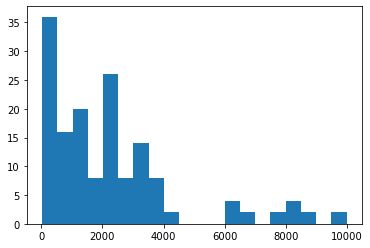

In [24]:
nz_nz_sub_d_idx = np.where(nz_sub_d.flatten()!=0)[0]
nz_nz_sub_d = nz_sub_d.flatten()[nz_nz_sub_d_idx]
plt.hist(nz_nz_sub_d, bins = 20)

In [26]:
transmit_cost = np.clip(nz_sub_d.flatten(), a_min = -np.inf, a_max = 8000) / 8000 * 0.5
np.save("USairport_2010/transmit_cost.npy", transmit_cost)

In [28]:
hub_ind = ind = np.argpartition(degree_list, -8)[-8:]
other_ind = np.array([15,23,35,40])
perturb_node = np.concatenate([hub_ind, other_ind])

In [30]:
np.save("USairport_2010/a.npy", nz_sub_a)
np.save("USairport_2010/d.npy", demand)
np.save("USairport_2010/u.npy", u)
np.save("USairport_2010/perturb_hub_index.npy", perturb_node)

In [11]:
nz_sub_a.shape[0]

49

In [29]:
perturb_node

array([36, 45, 38, 44,  8, 32, 20, 11, 15, 23, 35, 40])

## 66 node subnet

In [68]:
subnet_node = 150
subnet_idx = np.random.choice(match, subnet_node, replace = False)
sub_a = a[subnet_idx,:][:,subnet_idx]
sub_w = w[subnet_idx,:][:,subnet_idx]
sub_d = d[subnet_idx,:][:,subnet_idx]

In [69]:
nz_axis = np.where(np.sum(sub_a, axis = 0)!=0)[0]
nz_sub_a = sub_a[nz_axis,:][:,nz_axis]
nz_sub_w = sub_w[nz_axis,:][:,nz_axis]
nz_sub_d = sub_d[nz_axis,:][:,nz_axis]
#assert np.sum((nz_sub_a != 0) != (nz_sub_w!=0)) == 0
assert np.sum((nz_sub_a != 0) != (nz_sub_d!=0)) == 0
print(nz_sub_a.shape[0])

66


(array([24., 15.,  4.,  0.,  3.,  2.,  1.,  0.,  1.,  0.,  2.,  2.,  2.,
         0.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.        ,  1.97297297,  2.94594595,  3.91891892,  4.89189189,
         5.86486486,  6.83783784,  7.81081081,  8.78378378,  9.75675676,
        10.72972973, 11.7027027 , 12.67567568, 13.64864865, 14.62162162,
        15.59459459, 16.56756757, 17.54054054, 18.51351351, 19.48648649,
        20.45945946, 21.43243243, 22.40540541, 23.37837838, 24.35135135,
        25.32432432, 26.2972973 , 27.27027027, 28.24324324, 29.21621622,
        30.18918919, 31.16216216, 32.13513514, 33.10810811, 34.08108108,
        35.05405405, 36.02702703, 37.        ]),
 <BarContainer object of 37 artists>)

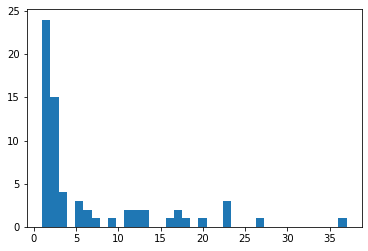

In [71]:
plt.hist(np.sum(nz_sub_a, axis = 0), bins = 37)

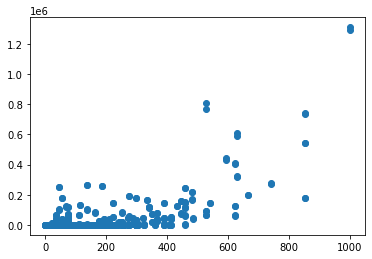

In [72]:
degree_list = np.sum(nz_sub_a, axis = 0)
product_of_degrees = []
weight_edge = []
for i in range(nz_sub_a.shape[0]):
    for j in range(nz_sub_a.shape[0]):
        if nz_sub_a[i,j] != 0:
            product_of_degrees.append(degree_list[i] * degree_list[j])
            weight_edge.append(nz_sub_w[i,j])
plt.scatter(product_of_degrees, weight_edge)

(array([4.054e+03, 1.570e+02, 8.000e+01, 3.900e+01, 1.400e+01, 3.000e+00,
        6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([2.5000e-03, 3.4450e-01, 6.8650e-01, 1.0285e+00, 1.3705e+00,
        1.7125e+00, 2.0545e+00, 2.3965e+00, 2.7385e+00, 3.0805e+00,
        3.4225e+00]),
 <BarContainer object of 10 artists>)

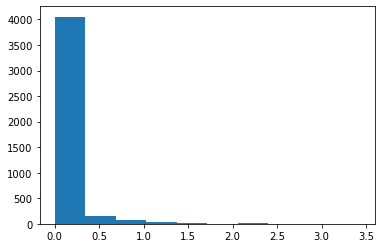

In [73]:
u = np.outer(degree_list, degree_list) / 400
plt.hist(u.flatten())

In [76]:
demand = []
for i in range(nz_sub_a.shape[0]):
    demand.append(np.sum(nz_sub_w, axis=1)[i] - np.sum(nz_sub_w, axis=0)[i])
demand = np.array(demand) / 4000

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
         1.,  4., 35., 12.,  3.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,
         2.]),
 array([-16.7985   , -16.2121125, -15.625725 , -15.0393375, -14.45295  ,
        -13.8665625, -13.280175 , -12.6937875, -12.1074   , -11.5210125,
        -10.934625 , -10.3482375,  -9.76185  ,  -9.1754625,  -8.589075 ,
         -8.0026875,  -7.4163   ,  -6.8299125,  -6.243525 ,  -5.6571375,
         -5.07075  ,  -4.4843625,  -3.897975 ,  -3.3115875,  -2.7252   ,
         -2.1388125,  -1.552425 ,  -0.9660375,  -0.37965  ,   0.2067375,
          0.793125 ,   1.3795125,   1.9659   ,   2.5522875,   3.138675 ,
          3.7250625,   4.31145  ,   4.8978375,   5.484225 ,   6.0706125,
          6.657    ]),
 <BarContainer object of 40 artists>)

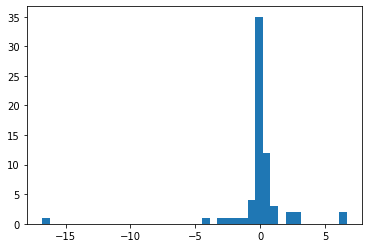

In [77]:
plt.hist(np.array(demand), bins = 40)

(array([112., 116.,  34.,  26.,  26.,  12.,   0.,   0.,  10.,  12.,  12.,
          4.,  10.,  10.,   4.,   8.,   0.,   0.,   2.,   4.]),
 array([   72.41014502,   803.05457104,  1533.69899706,  2264.34342308,
         2994.9878491 ,  3725.63227512,  4456.27670114,  5186.92112716,
         5917.56555318,  6648.2099792 ,  7378.85440522,  8109.49883124,
         8840.14325726,  9570.78768329, 10301.43210931, 11032.07653533,
        11762.72096135, 12493.36538737, 13224.00981339, 13954.65423941,
        14685.29866543]),
 <BarContainer object of 20 artists>)

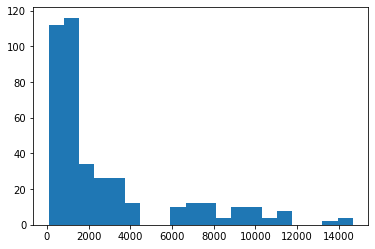

In [78]:
#distance between airports
nz_nz_sub_d_idx = np.where(nz_sub_d.flatten()!=0)[0]
nz_nz_sub_d = nz_sub_d.flatten()[nz_nz_sub_d_idx]
plt.hist(nz_nz_sub_d, bins = 20)

In [79]:
os.makedirs("USairport_2010_66", exist_ok=True)

In [80]:
transmit_cost = np.clip(nz_sub_d.flatten(), a_min = -np.inf, a_max = 8000) / 8000 * 0.5
np.save("USairport_2010_66/transmit_cost.npy", transmit_cost)

In [84]:
hub_ind = ind = np.argpartition(degree_list, -8)[-8:]
other_ind = np.array([18,25,36,51])
perturb_node = np.concatenate([hub_ind, other_ind])

In [85]:
np.save("USairport_2010_66/a.npy", nz_sub_a)
np.save("USairport_2010_66/d.npy", demand)
np.save("USairport_2010_66/u.npy", u)
np.save("USairport_2010_66/perturb_hub_index.npy", perturb_node)

In [83]:
hub_ind

array([ 5, 15, 38, 47, 11, 49, 55, 50])

In [19]:
pwd

'/mnt/nas/home/chenzhijie/research/resilient/network'

## 34 node subnet

In [33]:
subnet_node = 80
subnet_idx = np.random.choice(match, subnet_node, replace = False)
sub_a = a[subnet_idx,:][:,subnet_idx]
sub_w = w[subnet_idx,:][:,subnet_idx]
sub_d = d[subnet_idx,:][:,subnet_idx]

In [34]:
nz_axis = np.where(np.sum(sub_a, axis = 0)!=0)[0]
nz_sub_a = sub_a[nz_axis,:][:,nz_axis]
nz_sub_w = sub_w[nz_axis,:][:,nz_axis]
nz_sub_d = sub_d[nz_axis,:][:,nz_axis]
#assert np.sum((nz_sub_a != 0) != (nz_sub_w!=0)) == 0
assert np.sum((nz_sub_a != 0) != (nz_sub_d!=0)) == 0
print(nz_sub_a.shape[0])

34


(array([12.,  5.,  7.,  0.,  5.,  2.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 12 artists>)

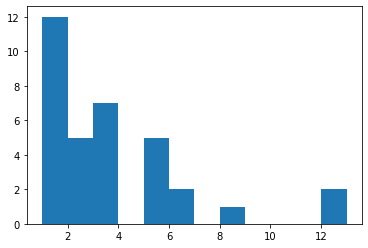

In [37]:
plt.hist(np.sum(nz_sub_a, axis = 0), bins = 12)

In [42]:
G = nx.from_numpy_matrix(nz_sub_a)
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[34]

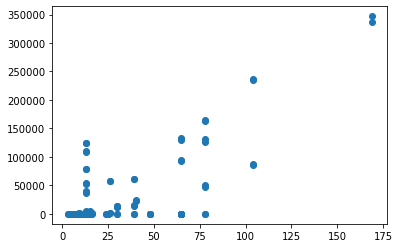

In [45]:
degree_list = np.sum(nz_sub_a, axis = 0)
product_of_degrees = []
weight_edge = []
for i in range(nz_sub_a.shape[0]):
    for j in range(nz_sub_a.shape[0]):
        if nz_sub_a[i,j] != 0:
            product_of_degrees.append(degree_list[i] * degree_list[j])
            weight_edge.append(nz_sub_w[i,j])
plt.scatter(product_of_degrees, weight_edge)

(array([966., 107.,  46.,  21.,   8.,   0.,   4.,   0.,   0.,   4.]),
 array([0.0125, 0.2225, 0.4325, 0.6425, 0.8525, 1.0625, 1.2725, 1.4825,
        1.6925, 1.9025, 2.1125]),
 <BarContainer object of 10 artists>)

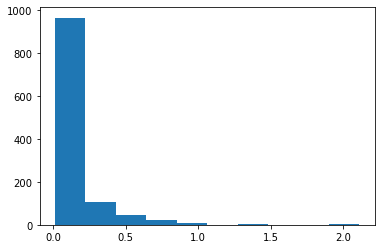

In [54]:
u = np.outer(degree_list, degree_list) / 80
plt.hist(u.flatten())

In [49]:
demand = []
for i in range(nz_sub_a.shape[0]):
    demand.append(np.sum(nz_sub_w, axis=1)[i] - np.sum(nz_sub_w, axis=0)[i])
demand = np.array(demand) / 2000

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  3.,  2., 18.,  5.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,
         1.]),
 array([-10.646   , -10.293125,  -9.94025 ,  -9.587375,  -9.2345  ,
         -8.881625,  -8.52875 ,  -8.175875,  -7.823   ,  -7.470125,
         -7.11725 ,  -6.764375,  -6.4115  ,  -6.058625,  -5.70575 ,
         -5.352875,  -5.      ,  -4.647125,  -4.29425 ,  -3.941375,
         -3.5885  ,  -3.235625,  -2.88275 ,  -2.529875,  -2.177   ,
         -1.824125,  -1.47125 ,  -1.118375,  -0.7655  ,  -0.412625,
         -0.05975 ,   0.293125,   0.646   ,   0.998875,   1.35175 ,
          1.704625,   2.0575  ,   2.410375,   2.76325 ,   3.116125,
          3.469   ]),
 <BarContainer object of 40 artists>)

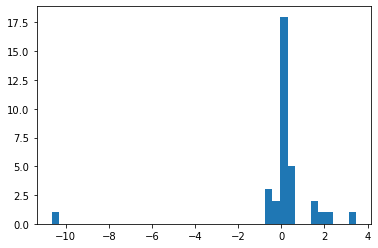

In [50]:
plt.hist(np.array(demand), bins = 40)

(array([36., 18.,  8., 10.,  6.,  8.,  4.,  0.,  0.,  2.,  4.,  6.,  0.,
         2.,  4.,  4.,  0.,  0.,  0.,  2.]),
 array([   55.80226163,   603.47778961,  1151.15331759,  1698.82884557,
         2246.50437355,  2794.17990152,  3341.8554295 ,  3889.53095748,
         4437.20648546,  4984.88201344,  5532.55754142,  6080.2330694 ,
         6627.90859738,  7175.58412536,  7723.25965334,  8270.93518132,
         8818.61070929,  9366.28623727,  9913.96176525, 10461.63729323,
        11009.31282121]),
 <BarContainer object of 20 artists>)

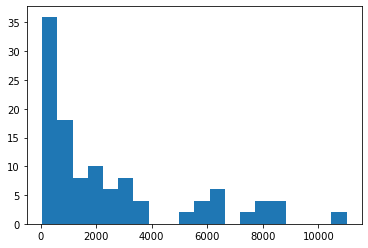

In [55]:
#distance between airports
nz_nz_sub_d_idx = np.where(nz_sub_d.flatten()!=0)[0]
nz_nz_sub_d = nz_sub_d.flatten()[nz_nz_sub_d_idx]
plt.hist(nz_nz_sub_d, bins = 20)

In [56]:
os.makedirs("USairport_2010_34", exist_ok=True)

In [58]:
transmit_cost = np.clip(nz_sub_d.flatten(), a_min = -np.inf, a_max = 8000) / 8000 * 0.5
np.save("USairport_2010_34/transmit_cost.npy", transmit_cost)

In [61]:
hub_ind = ind = np.argpartition(degree_list, -6)[-6:]
other_ind = np.array([7,12,17,29])
perturb_node = np.concatenate([hub_ind, other_ind])

In [60]:
hub_ind

array([18, 26, 30, 10, 22, 16])

In [62]:
np.save("USairport_2010_34/a.npy", nz_sub_a)
np.save("USairport_2010_34/d.npy", demand)
np.save("USairport_2010_34/u.npy", u)
np.save("USairport_2010_34/perturb_hub_index.npy", perturb_node)

In [63]:
z_init_1 = np.load("/mnt/nas/home/chenzhijie/research/pgd/problem_set/USairport_2010_76/76_64_2/z_init.npy")
z_init_2 = np.load("/mnt/nas/home/chenzhijie/research/resilient/problem_set/USairport_2010_76/76_64_2/z_init.npy")

In [65]:
np.linalg.norm(z_init_1 - z_init_2)

0.0

In [168]:
nz_sub_a = np.load("USairport_2010_34/a.npy")
demand = np.load("USairport_2010_34/d.npy")
u = np.load("USairport_2010_34/u.npy")
perturb_node = np.load("USairport_2010_34/perturb_hub_index.npy")
transmit_cost = np.load("USairport_2010_34/transmit_cost.npy")

In [119]:
degree_list = np.sum(nz_sub_a, axis = 1)

In [121]:
degree_list

array([ 2.,  3.,  1.,  1.,  5.,  1.,  3.,  1.,  2.,  3.,  8.,  1.,  3.,
        2.,  5.,  5., 13.,  1.,  5.,  5.,  3.,  2., 13.,  1.,  1.,  1.,
        6.,  3.,  3.,  1.,  6.,  1.,  1.,  2.])

In [122]:
degree_list[22]

13.0

In [129]:
demand

array([ 4.5000e-03, -6.5900e-01, -2.5000e-03, -1.3200e-01,  1.7585e+00,
        3.4050e-01,  9.0000e-03,  5.0000e-04, -8.0000e-03, -5.3000e-02,
        2.9500e-01, -1.0000e-03,  6.4400e-01,  2.9050e-01,  4.9000e-02,
       -3.5000e-03,  2.0990e+00,  6.2200e-01,  4.5450e-01, -6.4600e-01,
       -5.5000e-03, -5.5000e-03, -1.0646e+01,  2.6350e-01,  1.4690e+00,
       -1.0000e-03,  1.4910e+00,  4.0000e-03, -5.5000e-03, -4.3500e-02,
        3.4690e+00, -6.5950e-01, -5.0000e-04, -3.9150e-01])

In [131]:
demand[22]

-10.646

In [127]:
np.where(nz_sub_a[24])

(array([22]),)

In [92]:
np.where(nz_sub_a[14] != 0)

(array([ 8, 16, 18, 22, 25]),)

In [103]:
np.where(nz_sub_a[15] != 0)

(array([ 0, 19, 21, 27, 28]),)

In [109]:
np.sum(np.abs(demand))

26.527

In [116]:
np.sum(np.abs(demand[perturb_node]))

19.764500000000005

In [117]:
demand[perturb_node] -

array([ 4.5450e-01,  1.4910e+00,  3.4690e+00,  2.9500e-01, -1.0646e+01,
        2.0990e+00,  5.0000e-04,  6.4400e-01,  6.2200e-01, -4.3500e-02])

In [152]:
demand[5]

0.3405

In [118]:
perturb_node

array([18, 26, 30, 10, 22, 16,  7, 12, 17, 29])

In [147]:
y_gt_2 = np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_2_0.5_1.5/y_gt.npy")
delta_a_gt_2 =  np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_2_0.5_1.5/delta_a_gt.npy")
var_gt_2 = np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_2_0.5_1.5/var_gt.npy")

In [133]:
np.where(y_gt)

(array([16, 22]),)

In [135]:
np.where(delta_a_gt)

(array([ 5, 16]), array([16, 24]))

In [137]:
degree_list[30]

6.0

In [142]:
y_gt_0 = np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_0_0.5_1.5/y_gt.npy")
delta_a_gt_0 =  np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_0_0.5_1.5/delta_a_gt.npy")
var_gt_0 = np.load("/mnt/nas/home/chenzhijie/research/network/problem_set/USairport_2010_34/34_24_2_0_0.5_1.5/var_gt.npy")

In [140]:
np.where(delta_a_gt_0)

(array([], dtype=int64), array([], dtype=int64))

In [141]:
np.where(y_gt_0)

(array([16, 22]),)

In [146]:
var_gt_0[-34*2:]

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 3.77750e-01, 0.00000e+00,
       2.50000e-03, 0.00000e+00, 1.32000e-01, 0.00000e+00, 0.00000e+00,
       9.67500e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.00000e-04,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.30000e-02,
       2.95000e-01, 0.00000e+00, 0.00000e+00, 1.00000e-03, 6.44000e-01,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.22000e-01,
       0.00000e+00, 4.54500e-01, 0.00000e+00, 0.00000e+00, 6.38500e-01,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 5.50000e-03, 0.00000e+00,
       6.00700e+00, 1.97500e-02, 0.00000e+00, 1.22525e+00, 0.00000e+00,
       0.00000e+00, 1.00000e-03, 1.49100e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 4.50000e-03, 0.00000e+00, 4.35000e-02,
       3.46900e+00, 0.00000e+00, 0.00000e+00, 6.59500e-01, 0.00000e+00,
       5.00000e-04, 0.00000e+00, 3.91500e-01])

In [150]:
np.where(var_gt_2[-34*2:] - var_gt_0[-34*2:])

(array([10, 45, 46, 48, 52]),)

In [167]:
(var_gt_2[-34*2:] - var_gt_0[-34*2:])[48]

-0.24375000000000002

In [173]:
transmit_cost = transmit_cost.reshape((34,34))

In [174]:
transmit_cost[5,22]

0.373219356769917

In [175]:
transmit_cost[5,16]

0.0

In [176]:
u[5,22]

0.1625

In [177]:
transmit_cost[16,22]

0.13802786640594403

## 16 nodes subnet

In [ ]:
subnet_node = 50
subnet_idx = np.random.choice(match, subnet_node, replace = False)

In [299]:
for i in subnet_idx[connected_subnet_idx]:
    print(code_airport[match_idx[i]])

"GGT"
"FKL"
"YVR"
"FLL"
"SMR"
"ROC"
"CLE"
"SEA"
"RST"
"CAE"
"IFP"
"GCM"
"MAD"
"YHZ"
"MRY"
"CDG"


In [295]:
degree_list

array([1., 1., 3., 8., 1., 2., 8., 7., 3., 2., 5., 2., 1., 1., 3., 2.])

In [293]:
perturb_node

array([14,  8,  3,  6, 10,  7,  5, 11])

In [294]:
np.where(connected_sub_a)

(array([ 0,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         9,  9, 10, 10, 10, 10, 10, 11, 11, 12, 13, 14, 14, 14, 15, 15]),
 array([ 3,  6,  3,  7, 14,  0,  2,  4,  5,  6,  7, 11, 13,  3,  3,  6,  1,
         3,  5,  7,  8, 10, 11, 15,  2,  3,  6, 10, 12, 14, 15,  6,  9, 10,
         8, 10,  6,  7,  8,  9, 14,  3,  6,  7,  3,  2,  7, 10,  6,  7]))

In [286]:
code_airport[match_idx[1116]]

'"SEA"'

In [287]:
code_airport[match_idx[1071]]

'"ROC"'

In [288]:
code_airport[match_idx[189]]

'"CAE"'

In [289]:
len(code_airport)

1858

In [290]:
subnet_idx

array([ 443,  962, 1207,   47, 1099,  266,  396, 1271,  122, 1409,  398,
       1163, 1071,  231, 1116,  117, 1079, 1029,   54,  414,  607,  189,
       1402,   37,  188,  308,  253,  310,  548,  518,  431,  995, 1198,
        251, 1282, 1420, 1215, 1371,  919,  631,  749, 1270, 1376,  831,
        218,  198, 1119,  914,  350, 1432])

In [282]:
subnet_idx[connected_subnet_idx]

array([ 443,  396, 1409,  398, 1163, 1071,  231, 1116, 1079,  189,  548,
        431,  749, 1376,  831,  198])

In [230]:
sub_a = a[subnet_idx,:][:,subnet_idx]
sub_w = w[subnet_idx,:][:,subnet_idx]
sub_d = d[subnet_idx,:][:,subnet_idx]

In [231]:
nz_axis = np.where(np.sum(sub_a, axis = 0)!=0)[0]
nz_sub_a = sub_a[nz_axis,:][:,nz_axis]
nz_sub_w = sub_w[nz_axis,:][:,nz_axis]
nz_sub_d = sub_d[nz_axis,:][:,nz_axis]
#assert np.sum((nz_sub_a != 0) != (nz_sub_w!=0)) == 0
assert np.sum((nz_sub_a != 0) != (nz_sub_d!=0)) == 0
print(nz_sub_a.shape[0])

18


In [232]:
G = nx.from_numpy_matrix(nz_sub_a)
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[16, 2]

In [237]:
for sub_G in nx.connected_components(G):
    print(list(sub_G))
    connected_index = list(sub_G)
    break
connected_subnet_idx = nz_axis[connected_index]
connected_subnet_idx_in_a = subnet_idx[connected_subnet_idx]

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17]


In [234]:
connected_subnet_idx

array([ 0,  6,  9, 10, 11, 12, 13, 14, 16, 21, 28, 30, 40, 42, 43, 45])

In [245]:
connected_sub_a = sub_a[connected_subnet_idx,:][:,connected_subnet_idx]
connected_sub_w = sub_w[connected_subnet_idx,:][:,connected_subnet_idx]
connected_sub_d = sub_d[connected_subnet_idx,:][:,connected_subnet_idx]
connected_sub_d_full = d_full[connected_subnet_idx_in_a,:][:,connected_subnet_idx_in_a]

In [246]:
np.where(connected_sub_d_full == connected_sub_d)

(array([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15]),
 array([ 0,  3,  1,  6,  2,  3,  7, 14,  0,  2,  3,  4,  5,  6,  7, 11, 13,
         3,  4,  3,  5,  6,  1,  3,  5,  6,  7,  8, 10, 11, 15,  2,  3,  6,
         7, 10, 12, 14, 15,  6,  8,  9, 10,  8,  9, 10,  6,  7,  8,  9, 10,
        14,  3,  6, 11,  7, 12,  3, 13,  2,  7, 10, 14,  6,  7, 15]))

In [244]:
connected_sub_a[2,7]

1.0

(array([5., 4., 3., 0., 1., 0., 1., 2.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

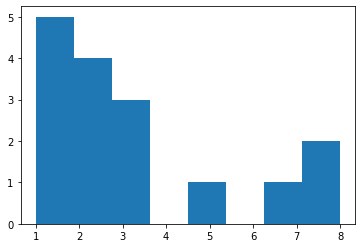

In [240]:
plt.hist(np.sum(connected_sub_a, axis = 0), bins = 8)

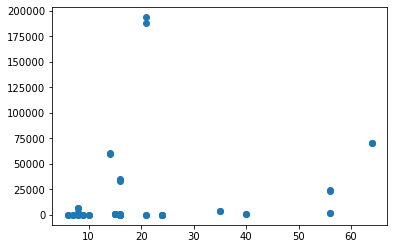

In [247]:
degree_list = np.sum(connected_sub_a, axis = 0)
product_of_degrees = []
weight_edge = []
for i in range(connected_sub_a.shape[0]):
    for j in range(connected_sub_a.shape[0]):
        if connected_sub_a[i,j] != 0:
            product_of_degrees.append(degree_list[i] * degree_list[j])
            weight_edge.append(connected_sub_w[i,j])
plt.scatter(product_of_degrees, weight_edge)

(array([155.,  37.,  30.,  19.,   0.,   2.,   4.,   1.,   4.,   4.]),
 array([0.125 , 0.9125, 1.7   , 2.4875, 3.275 , 4.0625, 4.85  , 5.6375,
        6.425 , 7.2125, 8.    ]),
 <BarContainer object of 10 artists>)

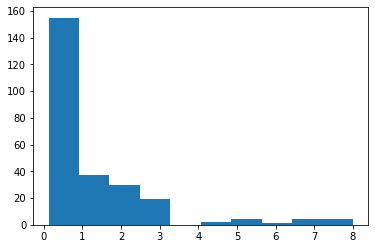

In [249]:
u = np.outer(degree_list, degree_list) / 8
plt.hist(u.flatten())

In [250]:
demand = []
for i in range(connected_sub_a.shape[0]):
    demand.append(np.sum(connected_sub_w, axis=1)[i] - np.sum(connected_sub_w, axis=0)[i])
demand = np.array(demand) / 2000

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 6.,
        3., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-2.6205 , -2.46415, -2.3078 , -2.15145, -1.9951 , -1.83875,
        -1.6824 , -1.52605, -1.3697 , -1.21335, -1.057  , -0.90065,
        -0.7443 , -0.58795, -0.4316 , -0.27525, -0.1189 ,  0.03745,
         0.1938 ,  0.35015,  0.5065 ,  0.66285,  0.8192 ,  0.97555,
         1.1319 ,  1.28825,  1.4446 ,  1.60095,  1.7573 ,  1.91365,
         2.07   ,  2.22635,  2.3827 ,  2.53905,  2.6954 ,  2.85175,
         3.0081 ,  3.16445,  3.3208 ,  3.47715,  3.6335 ]),
 <BarContainer object of 40 artists>)

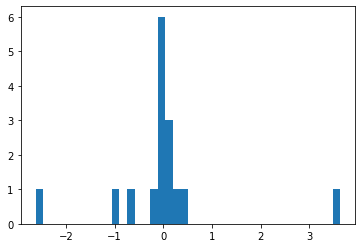

In [251]:
plt.hist(np.array(demand), bins = 40)

(array([10., 20., 22., 16., 18., 16., 14., 28.,  8., 14., 16.,  2.,  8.,
         8., 12.,  4.,  8.,  6.,  4.,  6.]),
 array([ 166.41725197,  628.3691809 , 1090.32110983, 1552.27303876,
        2014.22496769, 2476.17689662, 2938.12882555, 3400.08075448,
        3862.03268341, 4323.98461234, 4785.93654127, 5247.8884702 ,
        5709.84039913, 6171.79232806, 6633.74425699, 7095.69618591,
        7557.64811484, 8019.60004377, 8481.5519727 , 8943.50390163,
        9405.45583056]),
 <BarContainer object of 20 artists>)

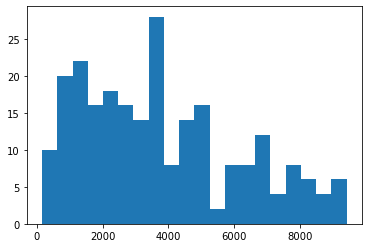

In [255]:
#distance between airports
nz_nz_sub_d_idx = np.where(connected_sub_d_full.flatten()!=0)[0]
nz_nz_sub_d = connected_sub_d_full.flatten()[nz_nz_sub_d_idx]
plt.hist(nz_nz_sub_d, bins = 20)

In [253]:
os.makedirs("USairport_2010_16", exist_ok=True)

In [259]:
transmit_cost = np.clip(connected_sub_d_full.flatten(), a_min = -np.inf, a_max = 8000) / 8000 * 0.1
np.save("USairport_2010_16/transmit_cost.npy", transmit_cost)

In [262]:
hub_ind = ind = np.argpartition(degree_list, -6)[-6:]
other_ind = np.array([5,11])
perturb_node = np.concatenate([hub_ind, other_ind])

In [264]:
perturb_node

array([14,  8,  3,  6, 10,  7,  5, 11])

In [265]:
np.save("USairport_2010_16/a.npy", connected_sub_a)
np.save("USairport_2010_16/d.npy", demand)
np.save("USairport_2010_16/u.npy", u)
np.save("USairport_2010_16/perturb_hub_index.npy", perturb_node)

In [267]:
demand[perturb_node]

array([ 0.041 , -0.013 ,  0.4665,  0.2695,  0.078 ,  3.6335, -1.041 ,
        0.088 ])

In [268]:
degree_list[perturb_node]

array([3., 3., 8., 8., 5., 7., 2., 2.])

In [271]:
a = np.load("USairport_2010_16/a.npy")
G = nx.from_numpy_matrix(a)

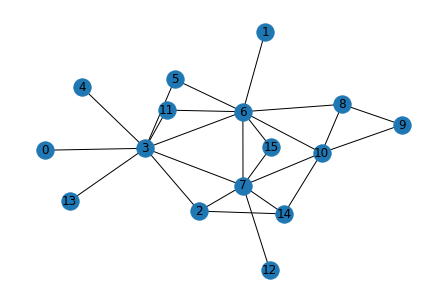

In [276]:
nx.draw(G, with_labels = True)

In [273]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [274]:
G.edges()

EdgeView([(0, 3), (1, 6), (2, 3), (2, 7), (2, 14), (3, 4), (3, 5), (3, 6), (3, 7), (3, 11), (3, 13), (5, 6), (6, 7), (6, 8), (6, 10), (6, 11), (6, 15), (7, 10), (7, 12), (7, 14), (7, 15), (8, 9), (8, 10), (9, 10), (10, 14)])

In [275]:
a

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

## plot statistics

In [302]:
import matplotlib
import seaborn as sns
import pandas as pd
import os
sns.set_theme(style="darkgrid")

font = {'weight': 'bold',
       'size': 10}
matplotlib.rc('font', **font)

In [327]:
subnet_node = 120
subnet_idx = np.random.choice(match, subnet_node, replace = False)
sub_a = a[subnet_idx,:][:,subnet_idx]
sub_w = w[subnet_idx,:][:,subnet_idx]
sub_d = d[subnet_idx,:][:,subnet_idx]

In [328]:
nz_axis = np.where(np.sum(sub_a, axis = 0)!=0)[0]
nz_sub_a = sub_a[nz_axis,:][:,nz_axis]
nz_sub_w = sub_w[nz_axis,:][:,nz_axis]
nz_sub_d = sub_d[nz_axis,:][:,nz_axis]
#assert np.sum((nz_sub_a != 0) != (nz_sub_w!=0)) == 0
assert np.sum((nz_sub_a != 0) != (nz_sub_d!=0)) == 0
print(nz_sub_a.shape[0])

49


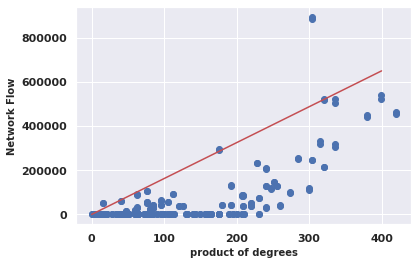

In [339]:
fig, ax = plt.subplots(figsize=(6,4))
degree_list = np.sum(nz_sub_a, axis = 0)
product_of_degrees = []
weight_edge = []
for i in range(nz_sub_a.shape[0]):
    for j in range(nz_sub_a.shape[0]):
        if nz_sub_a[i,j] != 0:
            product_of_degrees.append(degree_list[i] * degree_list[j])
            weight_edge.append(nz_sub_w[i,j])
plt.scatter(product_of_degrees, weight_edge)
plt.plot([0,400],[0,6.5*1e5], c='r')
ax.set_xlabel('product of degrees', fontsize=10, fontweight = "bold")
ax.set_ylabel('Network Flow', fontsize=10, fontweight = "bold")
plt.savefig('../plots/degree_flow.pdf',bbox_inches='tight')